In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install geopandas
!pip install pyshp

In [ ]:
from pandas.errors import InvalidIndexError
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import ast

# imports for the map
import geopandas as gpd
import shapely
from shapely.geometry import Polygon
from shapely import wkt
import shapefile as shp

# visualization
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable

# sns.set(style='whitegrid', palette='pastel', color_codes=True)
# sns.mpl.rc('figure', figsize=(10,6))
# sns.reset_orig

In [ ]:
preprocessed_directory = './drive/MyDrive/healthcare-weekly-patterns/'
# df = pd.read_csv(preprocessed_directory + 'weekly-patterns.csv')
# df.head()

In [ ]:
df.columns

Index(['safegraph_place_id', 'location_name', 'street_address', 'city',
       'region', 'postal_code', 'iso_country_code', 'safegraph_brand_ids',
       'brands', 'date_range_start', 'date_range_end', 'raw_visit_counts',
       'raw_visitor_counts', 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_country_of_origin', 'distance_from_home', 'median_dwell',
       'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_week_brand', 'device_type', 'carrier_name', 'placekey',
       'top_category', 'parent_placekey', 'parent_safegraph_place_id'],
      dtype='object')

In [ ]:
df_cbg = df[['safegraph_place_id', 'date_range_start', 'visitor_home_cbgs']]
df_cbg['date_range_start'] = df_cbg['date_range_start'].apply(lambda x: x[0:10])
df_cbg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,safegraph_place_id,date_range_start,visitor_home_cbgs
0,sg:0001ebcf9c274d46aeeaa153823d35d4,2020-09-14,{}
1,sg:0001ebcf9c274d46aeeaa153823d35d4,2020-10-05,{}
2,sg:000218c7676d442e858a879f12ee2013,2020-06-29,{}
3,sg:000218c7676d442e858a879f12ee2013,2020-07-27,{}
4,sg:000218c7676d442e858a879f12ee2013,2020-08-03,"{""CA:35204307"":4}"


In [ ]:
weeks_list = list(set(df_cbg['date_range_start']))
weeks_list.sort()
# weeks_list

In [ ]:
cbg_dict_wk = dict()
for wk in weeks_list:
  df_temp = df_cbg[df_cbg['date_range_start'] == wk]
  df_temp.drop(['safegraph_place_id', 'date_range_start'], axis=1, inplace=True)
  cbg_count_dict_list = df_temp['visitor_home_cbgs'].tolist() # create a list of dictionaries whose keys are cbg and values are counts
  cbg_count_dict_list = [ast.literal_eval(x) for x in cbg_count_dict_list if x != '{}'] # removes empty dictionaries
  cbg_count_dict = dict()
  for item in cbg_count_dict_list: # item is a dict in this list
    for d_item in item.keys(): # d_item is a key in the dict
      if cbg_count_dict.get(d_item) is None:
        cbg_count_dict[d_item] = 0
      cbg_count_dict[d_item] += item[d_item]
  cbg_dict_wk[wk] = cbg_count_dict

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
cbg_dict_wk

In [ ]:
# Get the aggregated cdg count 
cdg_dict = {}
for mydict in cbg_dict_wk.values():
  for cbg, count in mydict.items():
    if cbg in cdg_dict: 
      cdg_dict[cbg] += count
    else:
      cdg_dict[cbg] = count
# cdg_dict
print(len(cdg_dict))

13106


Clustering

In [ ]:
from sklearn.cluster import KMeans
arr = np.array([ [x] for x in cdg_dict.values() ])
kmeans = KMeans(n_clusters=3, random_state=0).fit(arr)
label_df = pd.DataFrame(kmeans.labels_.astype('int64'))
df_cluster = pd.DataFrame(cdg_dict.items(), columns=['cbg', 'counts'])
df_cluster['cluster'] = label_df
df['cluster'].loc[(df['cluster'] == 1)] = 3
df['cluster'].loc[(df['cluster'] == 2)] = 1
df['cluster'].loc[(df['cluster'] == 3)] = 2
df_cluster.to_csv('./drive/MyDrive/cluster.csv',index=False)

In [ ]:
cluster_plot = {}

# change cluster.csv to a dictionary, key:cdg,  value:cluster label
lookup = dict(zip(df_cluster.cbg, df_cluster.cluster))

for date, item in cbg_dict_wk.items():
  l0, l1, l2 = [], [], []
  for cdg, count in item.items():
    if lookup[cdg] == 0:
      l0.append(count)
    elif lookup[cdg] == 1:
      l1.append(count)
    else:
      l2.append(count)

  cluster_count = {0: np.mean(l0), 1: np.mean(l1), 2: np.mean(l2)}
  cluster_plot[date] = cluster_count

cluster_plot # date: {cluster: Avg_counts}

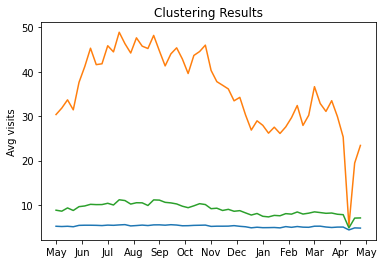

In [ ]:
# This is for plot three lines over time
l0, l1, l2 = [], [], []
for x in cluster_plot.values():
  l0.append(x[0])
  l1.append(x[1])
  l2.append(x[2])

# import matplotlib.pyplot as plt
plt.title('Clustering Results')
plt.plot(l0)
plt.plot(l1)
plt.plot(l2)
plt.ylabel('Avg visits')
months = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
plt.xticks(np.linspace(0,54,13), months)
plt.show()

For the map

In [ ]:
df_cluster = pd.read_csv('./drive/MyDrive/cluster.csv')
df_cluster['cbg'] = df_cluster['cbg'].apply(lambda x: x[3:])
df_cluster.head()

,cbg,counts,cluster
0,35180101,112,0
1,35181002,189,0
2,35202162,135,0
3,35201390,378,1
4,35201381,182,0


In [ ]:
gdf = gpd.read_file(preprocessed_directory + 'lda_000b21a_e/' + 'lda_000b21a_e.shp')
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf = gdf[gdf['DAUID'].isin(df_cluster['cbg'])]
gdf.reset_index(inplace=True)
gdf.drop(['index', 'DGUID', 'LANDAREA', 'PRUID',], inplace=True, axis=1)
gdf.columns = ['cbg', 'geometry']
gdf.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,cbg,geometry
0,10010175,"POLYGON ((-52.75683 47.53784, -52.75638 47.537..."
1,10010232,"POLYGON ((-52.72505 47.56509, -52.72518 47.564..."
2,10010246,"POLYGON ((-52.75041 47.56403, -52.75143 47.564..."
3,10010250,"POLYGON ((-52.72500 47.56845, -52.72810 47.568..."
4,10010504,"MULTIPOLYGON (((-53.12645 47.81702, -53.12663 ..."


In [ ]:
cluster_gdf = gdf.merge(df_cluster, on='cbg', how='inner')
cluster_gdf.head()

,cbg,geometry,counts,cluster
0,10010175,"POLYGON ((-52.75683 47.53784, -52.75638 47.537...",4,0
1,10010232,"POLYGON ((-52.72505 47.56509, -52.72518 47.564...",4,0
2,10010246,"POLYGON ((-52.75041 47.56403, -52.75143 47.564...",4,0
3,10010250,"POLYGON ((-52.72500 47.56845, -52.72810 47.568...",5,0
4,10010504,"MULTIPOLYGON (((-53.12645 47.81702, -53.12663 ...",8,0


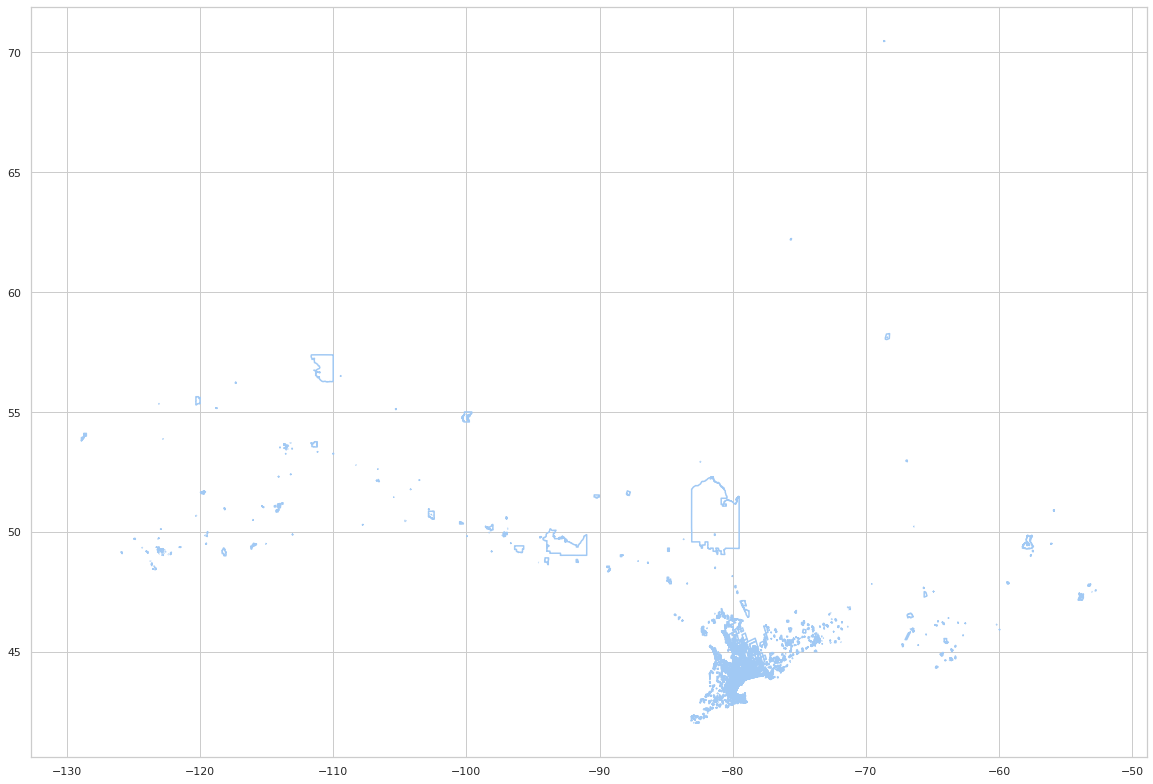

In [ ]:
ax = cluster_gdf['geometry'].boundary.plot(figsize=(20,16))

In [ ]:
def map_to_color(x):
  colors = ['#187323', '#C62828', '#FF9800'] # cluster 0 - green (low), cluster 1 - red (high), cluster 2 - yellow (med)
  return colors[x['cluster']]

cluster_gdf['color'] = cluster_gdf.apply(map_to_color, axis=1)

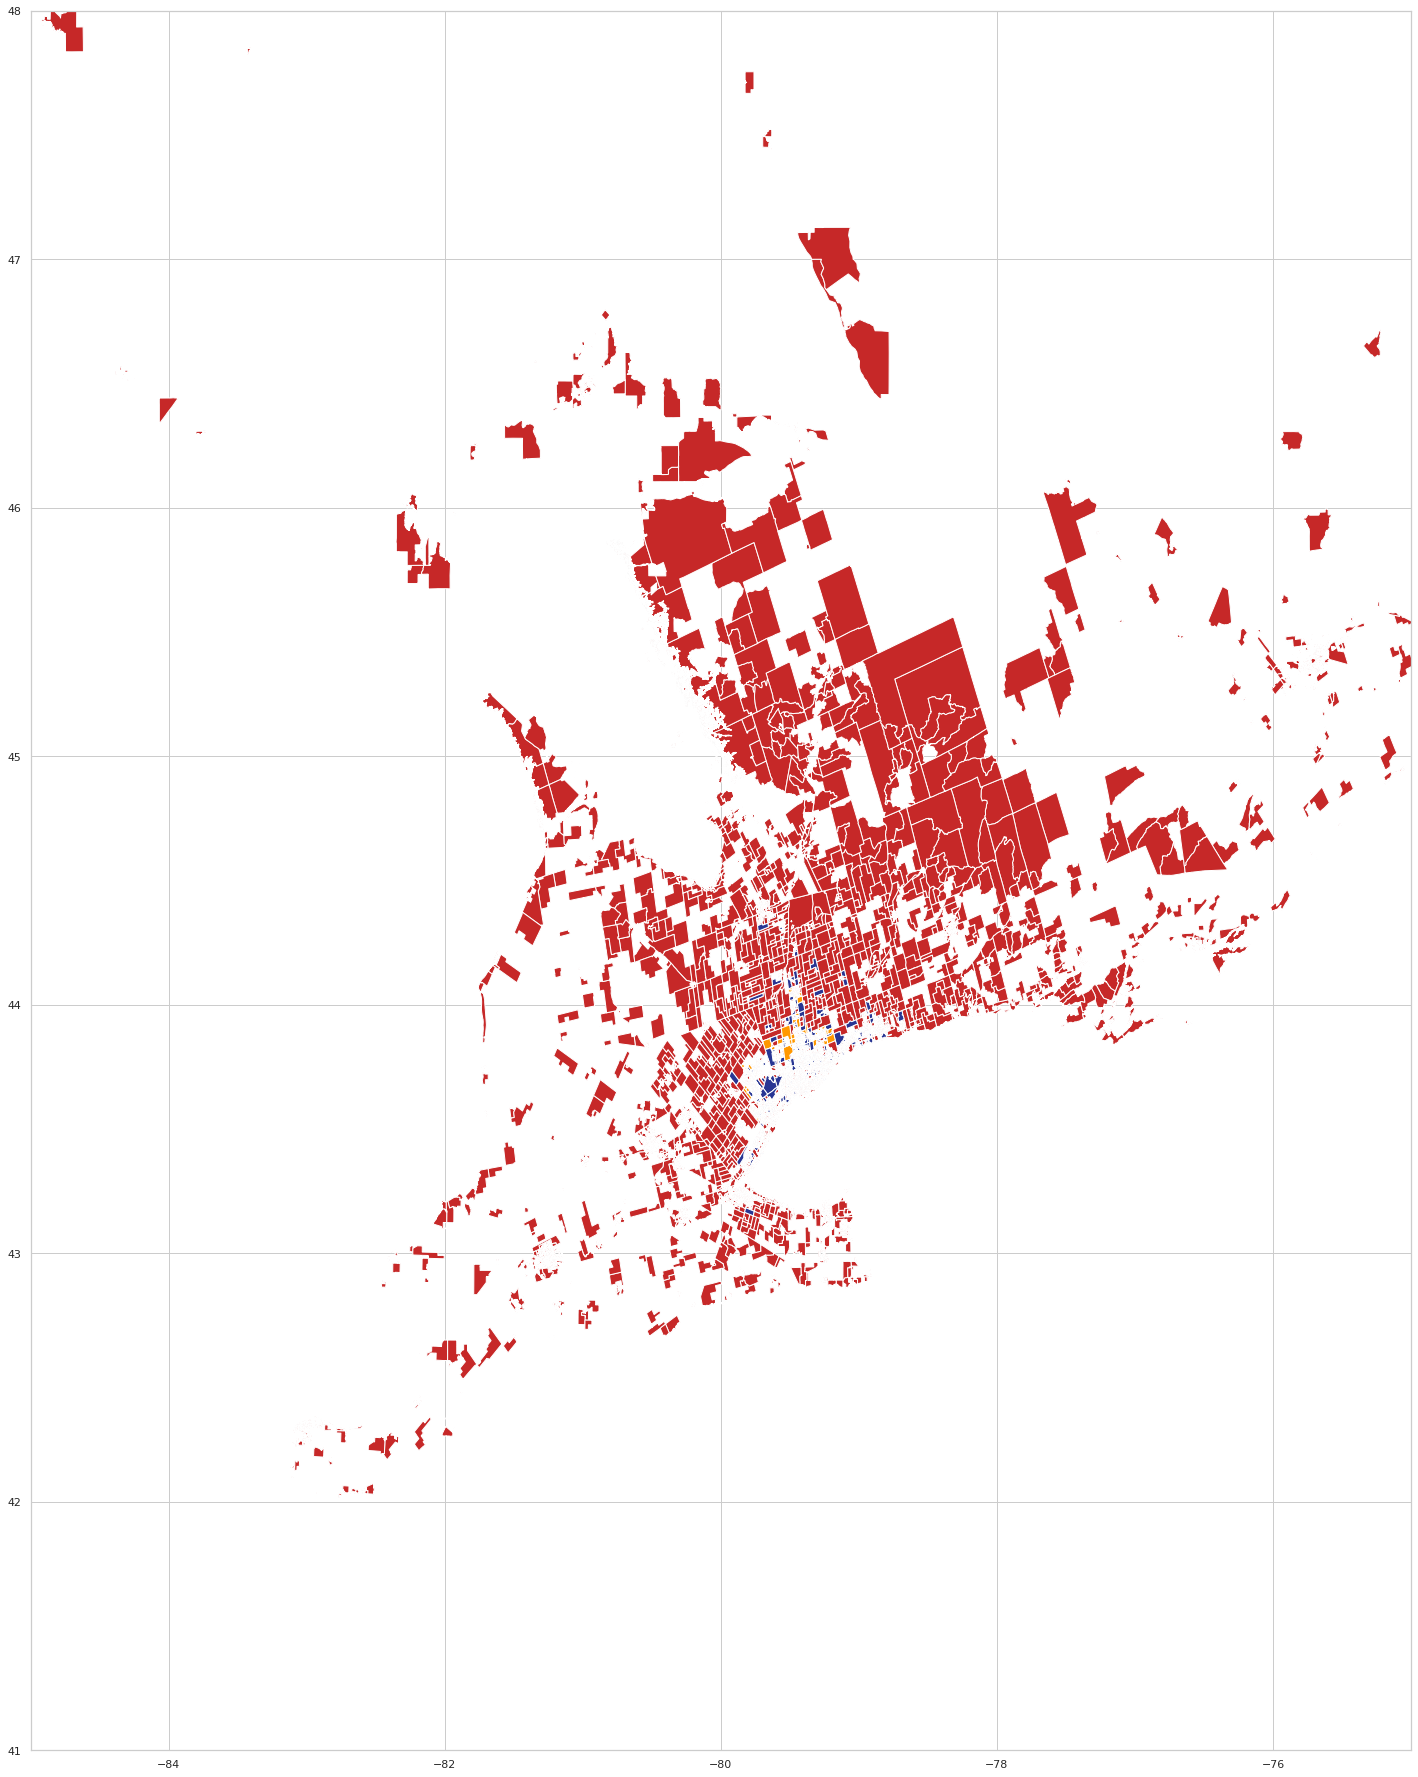

In [ ]:
fig, ax = plt.subplots(figsize=(40,32))
ax.set_xlim(-85,-75)
ax.set_ylim(41, 48)
cluster_gdf.plot(color=cluster_gdf['color'], ax=ax)

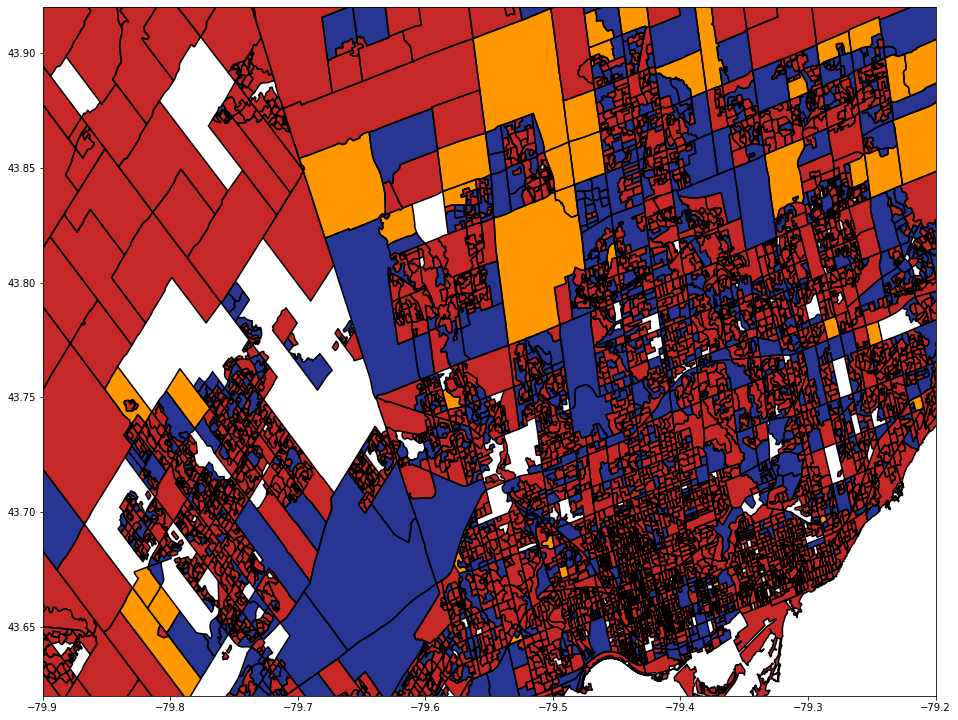

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 20))
ax = cluster_gdf['geometry'].boundary.plot(figsize=(16, 20), color='k')
ax.set_xlim(-79.9,-79.2)
ax.set_ylim(43.62, 43.92)
cluster_gdf.plot(color=cluster_gdf['color'], ax=ax)

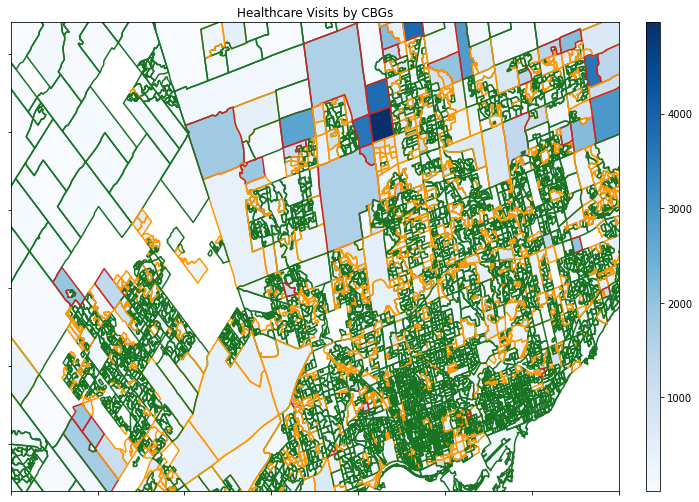

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 20))
ax = cluster_gdf['geometry'].boundary.plot(figsize=(16, 20), color=cluster_gdf['color'])
ax.set_xlim(-79.9,-79.2)
ax.set_ylim(43.62, 43.92)
ax.set_title('Healthcare Visits by CBGs')
ax.set(yticklabels=[], xticklabels=[])
# cluster_gdf.plot(color=cluster_gdf['color'], ax=ax)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=0.2, pad=-3)
# legend_dict = {'label': 'Healthcare Visits by CBGs'}
cluster_gdf.plot(column='counts', ax=ax, legend=True, cax=cax, cmap='Blues')

In [ ]:
def map_to_color2(x):
  colors = ['#66de80', '#fffb00', '#ff9305'] # cluster 0 - green (low), cluster 2 - red (high), cluster 1 - yellow (med)
  return colors[x['cluster']]

cluster_gdf['color2'] = cluster_gdf.apply(map_to_color2, axis=1)

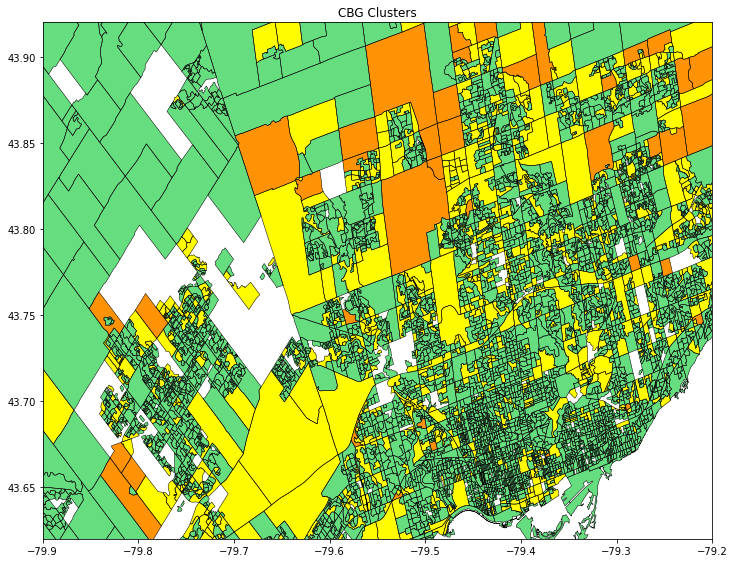

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 20))
# ax = cluster_gdf['geometry'].boundary.plot(figsize=(12, 16), color=cluster_gdf['color'])
ax = cluster_gdf['geometry'].boundary.plot(figsize=(12, 16), color='k', linewidth=0.5)
xlim_min, xlim_max = -79.9, -79.2
ylim_min, ylim_max = 43.62, 43.92
# xlim_min, xlim_max = -79.45, -79.25
# ylim_min, ylim_max = 43.63, 43.70
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_title('CBG Clusters')
# ax.set(yticklabels=[], xticklabels=[])
# cluster_gdf.plot(color=cluster_gdf['color'], ax=ax)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size=0.2, pad=-3)
# legend_dict = {'label': 'Healthcare Visits by CBGs'}
# cluster_gdf.plot(color='white', ax=ax)
cluster_gdf.plot(color=cluster_gdf['color2'], ax=ax)

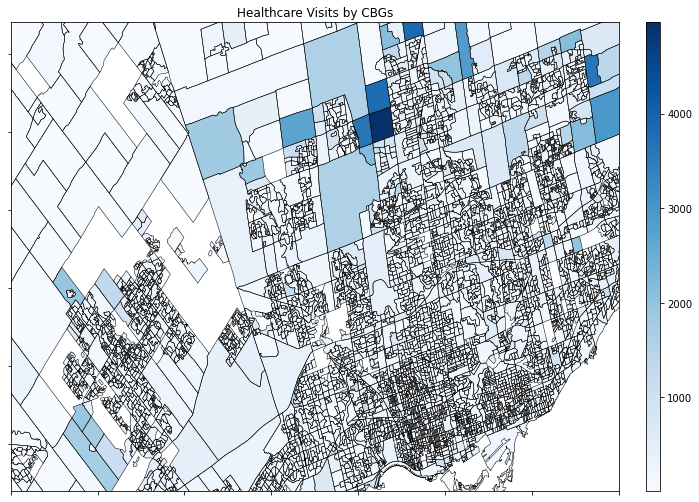

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 20))
ax = cluster_gdf['geometry'].boundary.plot(figsize=(16, 20), color='k', linewidth=0.5)
xlim_min, xlim_max = -79.9, -79.2
ylim_min, ylim_max = 43.62, 43.92
# xlim_min, xlim_max = -79.45, -79.25
# ylim_min, ylim_max = 43.63, 43.70
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_title('Healthcare Visits by CBGs')
ax.set(yticklabels=[], xticklabels=[])
# cluster_gdf.plot(color=cluster_gdf['color'], ax=ax)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=0.2, pad=-3)
# legend_dict = {'label': 'Healthcare Visits by CBGs'}
cluster_gdf.plot(column='counts', ax=ax, legend=True, cax=cax, cmap='Blues')